In [1]:
# load heatsequer and other modules
%matplotlib notebook
import heatsequer as hs
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

/Users/amnon/anaconda/envs/juphub/lib/python3.5/site-packages/matplotlib/__init__.py:1350: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


('loading cooldb',)
('cooldb loaded',)
('loading bactdb',)
('bactdb loaded',)
('loading supercooldb',)
('supercooldb loaded',)


In [2]:
# set display to full width
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

# loading data

## Se jin fecal stability study

In [4]:
# load se jin storage study
sj=hs.load('/Users/amnon/Projects/bloom-filtering/data/storage.sejin.clean.withtax.biom','/Users/amnon/Projects/bloom-filtering/data/map.storage.sejin.txt')

('Loading biom table',)
09bf10ab84c3314a11407ba28180b370
('Loading mapping file /Users/amnon/Projects/bloom-filtering/data/map.storage.sejin.txt',)
('number of samples in map is 1142',)
('number of samples in table is 1525',)
('Table sample H1.rep2.amb.fresh.II not found in mapping file',)
('Table sample BLANK.7.12G not found in mapping file',)
('Table sample H5.rep1.amb.fresh.II not found in mapping file',)
('Table sample D1.rep3.amb.fresh.II not found in mapping file',)
('Table sample H5.rep2.amb.8weeks.II not found in mapping file',)
('Table sample D3.70etoh.4C.8weeks.II not found in mapping file',)
('Table sample H2.rep5.amb.fresh.II not found in mapping file',)
('Table sample H8.rep5.amb.8weeks.II not found in mapping file',)
('Table sample BLANK.8.11H not found in mapping file',)
('Table sample H4.70etoh.amb.fresh.II not found in mapping file',)
('Table sample BLANK.12.12H not found in mapping file',)
('Table sample D2.rep2.amb.8weeks.II not found in mapping file',)
('Table sampl

In [5]:
# and keep only RT no preservative
# get no preservative
sjf=hs.filtersamples(sj,'preservative','None')
# and only room temp
sjf=hs.filtersamples(sjf,'temperature','amb')

('220 Samples left',)
('75 Samples left',)


In [6]:
sjf=hs.filterorigreads(sjf,1000)

('75 Samples left',)


## Mayo fecal stability study

In [7]:
mayo=hs.load('/Users/amnon/Projects/bloom-filtering/data/mayo.new.min10.clean.withtax.biom','/Users/amnon/Projects/bloom-filtering/data/map.mayo1.txt')

('Loading biom table',)
acbfaf6d2e684236fb7a5dca190c212e
('Loading mapping file /Users/amnon/Projects/bloom-filtering/data/map.mayo1.txt',)
('number of samples in map is 960',)
('number of samples in table is 958',)
('removing 0 samples',)
('deleted. number of samples in table is now 958',)
('removing 2 samples from mapping file',)
('number of samples in mapping file is now 958',)
Samples with 0 reads: 18


In [8]:
# only no treatment
mayof=hs.filtersamples(mayo,'TREATMENT','No Additive')

('252 Samples left',)


In [9]:
mayof=hs.filterorigreads(mayof,1000)

('242 Samples left',)


## american gut

In [10]:
ag=hs.load('/Users/amnon/Projects/bloom-filtering/data/ag-6-2016.clean.min100.withtax.biom','/Users/amnon/Projects/bloom-filtering/data/map.ag-6-2016.txt')

('Loading biom table',)
5ffd56560ea3217b52a6076d5dd5d2f6
('Loading mapping file /Users/amnon/Projects/bloom-filtering/data/map.ag-6-2016.txt',)
('number of samples in map is 9919',)
('number of samples in table is 9919',)
('removing 0 samples',)
('deleted. number of samples in table is now 9919',)
('number of samples in mapping file is now 9919',)
Samples with 0 reads: 1214


In [11]:
# get only fecal
agf=hs.filtersamples(ag,'ENV_MATTER','ENVO:feces')

('7286 Samples left',)


In [12]:
agf=hs.convertdatefield(agf,'COLLECTION_DATE','date-numeric','%m/%d/%Y')

('1 conversions failed',)


In [13]:
agf=hs.sortsamples(agf,'date-numeric',numeric=True)

In [14]:
agf=hs.filterorigreads(agf,1000)

('7073 Samples left',)


## UK twins study

In [15]:
twins=hs.load('/Users/amnon/Projects/bloom-filtering/data/twins2.clean.min10.withtax.biom','/Users/amnon/Projects/bloom-filtering/data/map.twins2.txt')

('Loading biom table',)
d16fcd8fbbae6b25cbd464ab73950ba1
('Loading mapping file /Users/amnon/Projects/bloom-filtering/data/map.twins2.txt',)
('number of samples in map is 1081',)
('number of samples in table is 1046',)
('removing 0 samples',)
('deleted. number of samples in table is now 1046',)
('removing 35 samples from mapping file',)
('number of samples in mapping file is now 1046',)
Samples with 0 reads: 29


In [16]:
# keep only high freq. enough bacteria
twinsf=hs.clusterbacteria(twins,50)

('2564 Bacteria left',)


In [17]:
twins=hs.filterorigreads(twins,1000)

('1017 Samples left',)


## PGP

In [18]:
pgp=hs.load('/Users/amnon/Projects/bloom-filtering/data/pgp.baylor.clean.withtax.biom','/Users/amnon/Projects/bloom-filtering/data/map.pgp.txt')

('Loading biom table',)
7ca155612b152a9b7b20540489072e8e
('Loading mapping file /Users/amnon/Projects/bloom-filtering/data/map.pgp.txt',)
('number of samples in map is 429',)
('number of samples in table is 437',)
('Table sample Fermanagh.Mouth not found in mapping file',)
('Table sample Elmira.Stool not found in mapping file',)
('Table sample Erlandson.Stool not found in mapping file',)
('Table sample Innkeeper.Forehead not found in mapping file',)
('Table sample Tewmac.Mouth not found in mapping file',)
('Table sample Pinrock.Rightpalm not found in mapping file',)
('Table sample Lippokd.Forehead not found in mapping file',)
('Table sample Delmore.Leftpalm not found in mapping file',)
('Table sample Goddu.Forehead not found in mapping file',)
('Table sample Menekish.Stool not found in mapping file',)
('removing 10 samples',)
('deleted. number of samples in table is now 427',)
('removing 2 samples from mapping file',)
('number of samples in mapping file is now 427',)
Samples with 0 rea

In [19]:
# only fecal samples
pgpf=hs.filtersamples(pgp,'#SampleID','Stool',exact=False)

('80 Samples left',)


In [20]:
pgpf=hs.filterorigreads(pgpf,1000)

('79 Samples left',)


In [21]:
pgpf=hs.clusterbacteria(pgpf,10)

('1378 Bacteria left',)


## ercolini whole grain feces

In [22]:
erc=hs.load('data/ercolini.feces.clean.withtax.biom','data/map.ercolini.txt')

('Loading biom table',)
2ad21c8bdf0b14e5c60dc29494838d15
('Loading mapping file data/map.ercolini.txt',)
('number of samples in map is 96',)
('number of samples in table is 93',)
('removing 0 samples',)
('deleted. number of samples in table is now 93',)
('removing 3 samples from mapping file',)
('number of samples in mapping file is now 93',)
Samples with 0 reads: 4


In [23]:
ercf=hs.filtersamples(erc,'env_matter','ENVO:feces')

('89 Samples left',)


In [24]:
ercf=hs.filterorigreads(ercf,1000)

('88 Samples left',)


## Gevers IBD

In [25]:
ibd=hs.load('data/ibd.clean.withtax.biom','data/map.ibd.txt')

('Loading biom table',)
446d627628b7864be31cf8b41aa08443
('Loading mapping file data/map.ibd.txt',)
('number of samples in map is 1957',)
('number of samples in table is 1957',)
('removing 0 samples',)
('deleted. number of samples in table is now 1957',)
('number of samples in mapping file is now 1957',)
Samples with 0 reads: 8


In [26]:
ibdf=hs.filtersamples(ibd,'sample_type','stool')

('518 Samples left',)


In [27]:
ibdf=hs.filtersamples(ibdf,'Diagnosis','control')

('30 Samples left',)


In [28]:
ibdf=hs.clusterbacteria(ibdf,3)

('843 Bacteria left',)


In [29]:
ibdf=hs.filterorigreads(ibdf,1000)

('30 Samples left',)


## parkinson - payami (shipped)

In [84]:
par=hs.load('data/parkinson.payami.min10.clean.withtax.biom','data/map.parkinson.txt')

('Loading biom table',)
ae70001cbcb3a821e111320f4264a95c
('Loading mapping file data/map.parkinson.txt',)
('number of samples in map is 384',)
('number of samples in table is 376',)
('removing 0 samples',)
('deleted. number of samples in table is now 376',)
('removing 8 samples from mapping file',)
('number of samples in mapping file is now 376',)
Samples with 0 reads: 28


In [85]:
parf=hs.filterorigreads(par,1000)

('340 Samples left',)


In [88]:
parf=hs.filtersamples(parf,'env_matter','ENVO:feces')

('335 Samples left',)


In [89]:
parf=hs.clusterbacteria(parf,10)

('3279 Bacteria left',)


# Analysis

## Calculate growth for bacteria in storage studies

In [195]:
def teststability(expdat,time0val='1',time1val='2',temp='amb',mincut=5,upres=False,time0temp='amb',timefield='time_numeric',tempfield='temp2',subjectfield='subject',presfield='preservative',printthresh=1000):
    """
    calculate foldchange for all bacteria in storage experiment
    
    input:
    expdat - the experiment
    time0val - value for timepoint 0 (i.e. '1')
    time1val - value for timepoint 1 (i.e. '2' or '4')
    temp - the temperature (i.e. 'amb' or '20C' or 'Heat')
    mincut - the minimal number of reads (out of 10k) to round the number of reads to (to remove effect of discretization on small numbers)
    saveto - dir name to append the result statistics and figures or False to skip
    upres - False to do on all preservatives, otherwise list of unique preservatives (in order)
    time0temp - the temperature for time0 samples (default 'amb')

    output:
    fc : dict of float
        the log2 fold change per otu (keyed by sequence)
    """
    fc={}
    # keep only samples with enough reads
    expdat=hs.filterorigreads(expdat,2500)
    if tempfield=='':
        expdat0=hs.copyexp(expdat)
    else:
        expdat0=hs.filtersamples(expdat,tempfield,time0temp,exact=True)
        expdat=hs.filtersamples(expdat,tempfield,temp,exact=True)

    ids=hs.getfieldvals(expdat,subjectfield)
    uids=list(set(ids))
    pres=hs.getfieldvals(expdat,presfield,ounique=True)
    if len(pres)>1:
        raise RunTimeError('more than 1 preservative!!!')

    allvalsdict={}
    rat=[]
    for cid in expdat.sids:
        rat.append([])

    atime0=hs.filtersamples(expdat0,timefield,time0val)
    atime1=hs.filtersamples(expdat,timefield,time1val)
    allx=[]
    ally=[]
    ccall=[]
    for ididx,cid in enumerate(uids):
        tp1=hs.findsamples(atime1,subjectfield,cid)
        tp0=hs.findsamples(atime0,subjectfield,cid)
        if len(tp1)==0:
            continue
        if len(tp0)==0:
            continue

        if len(tp0)>1:
            time0m=np.mean(atime0.data[:,tp0],1)
        else:
            time0m=atime0.data[:,tp0[0]]
        if len(tp1)>1:
            time1m=np.mean(atime1.data[:,tp1],1)
        else:
            time1m=atime1.data[:,tp1[0]]

        for otuidx,cid in enumerate(atime0.sids):
            if time0m[otuidx]<mincut:
                if time1m[otuidx]<mincut:
                    continue
                else:
                    time0m[otuidx]=mincut
            if time1m[otuidx]<mincut:
                time1m[otuidx]=mincut
            rat[otuidx].append(float(time1m[otuidx])/time0m[otuidx])
    vals=[]
    allvals=[]
    fids=[]
    ftax=[]
    fseqs=[]
    for idx,crat in enumerate(rat):
        if len(crat)>0:
            vals.append(np.log2(np.mean(crat)))
            allvals.append(np.log2(np.mean(crat)))
            fids.append(expdat.sids[idx])
            ftax.append(expdat.tax[idx])
            fseqs.append(expdat.seqs[idx])
        else:
            allvals.append(0)
    print("number of outliers (10 fold) %d" % np.sum(np.abs(vals)>=np.log2(10)))
    print("fraction of outliers (10 fold) %f" % (float(np.sum(np.abs(vals)>=np.log2(10)))/len(vals)))
    print("mean abs log2 fold change %f" % np.mean(np.abs(vals)))
    print("median abs log2 fold change %f" % np.median(np.abs(vals)))

    outseqs={}
    # print the resulting otus
    for idx,cval in enumerate(vals):
        outseqs[fseqs[idx]]=2**cval
        if abs(cval)>=np.log2(printthresh):
            print('%f\t%f\t%s\t%s\n' % (2**cval, cval, fids[idx], ftax[idx]))

    plt.figure()
    plt.hist(allvals,100)
    plt.yscale('log')
    plt.ylim([0.5,len(allvals)])
    plt.ylabel('# of otus')
    plt.xlabel('log2(fold change)')
    
    return outseqs

('241 Samples left',)
('92 Samples left',)
('74 Samples left',)
number of outliers (10 fold) 8
fraction of outliers (10 fold) 0.011817
mean abs log2 fold change 0.567105
median abs log2 fold change 0.384915


<IPython.core.display.Javascript object>


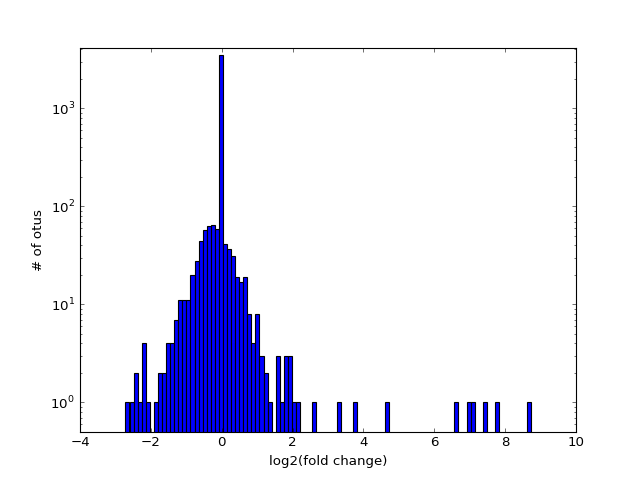

In [196]:
# mayo 4 days
mayo4fc=teststability(mayof,timefield='SAMPLE_VISIT',time0val='Day 0',time1val='Day 4',subjectfield='HOST_SUBJECT_ID',presfield='TREATMENT',tempfield='')

('241 Samples left',)
('92 Samples left',)
('75 Samples left',)
number of outliers (10 fold) 6
fraction of outliers (10 fold) 0.008915
mean abs log2 fold change 0.412695
median abs log2 fold change 0.276347


<IPython.core.display.Javascript object>


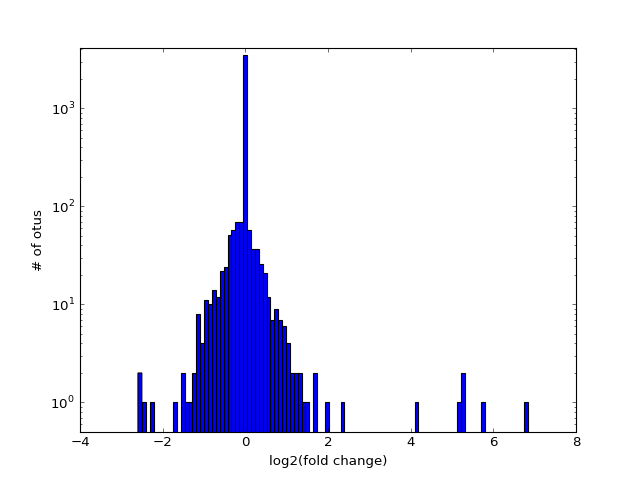

In [197]:
# mayo 1 day
mayo1fc=teststability(mayof,timefield='SAMPLE_VISIT',time0val='Day 0',time1val='Day 1',subjectfield='HOST_SUBJECT_ID',presfield='TREATMENT',tempfield='')

('75 Samples left',)
('75 Samples left',)
('75 Samples left',)
('15 Samples left',)
('15 Samples left',)
number of outliers (10 fold) 8
fraction of outliers (10 fold) 0.011527
mean abs log2 fold change 0.867410
median abs log2 fold change 0.713038


<IPython.core.display.Javascript object>


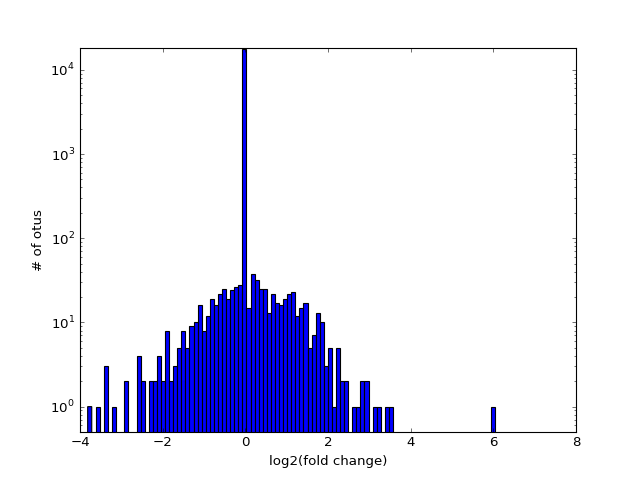

In [199]:
# se jin 1 week
sj7fc=teststability(sjf,time0val='1',time1val='2')

('75 Samples left',)
('75 Samples left',)
('75 Samples left',)
('15 Samples left',)
('15 Samples left',)
number of outliers (10 fold) 39
fraction of outliers (10 fold) 0.051316
mean abs log2 fold change 1.234416
median abs log2 fold change 0.979320


<IPython.core.display.Javascript object>


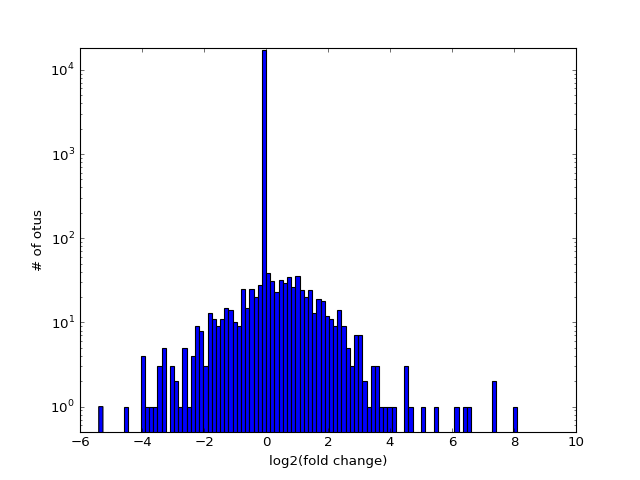

In [198]:
# se jin 2 weeks
sj14fc=teststability(sjf,time0val='1',time1val='3')

('75 Samples left',)
('75 Samples left',)
('75 Samples left',)
('15 Samples left',)
('30 Samples left',)
number of outliers (10 fold) 65
fraction of outliers (10 fold) 0.085526
mean abs log2 fold change 1.430598
median abs log2 fold change 1.107019
1327.916470	10.374949	7054443	Bacteria;Firmicutes;Bacilli;Bacillales;Planococcaceae;Rummeliibacillus;;



<IPython.core.display.Javascript object>


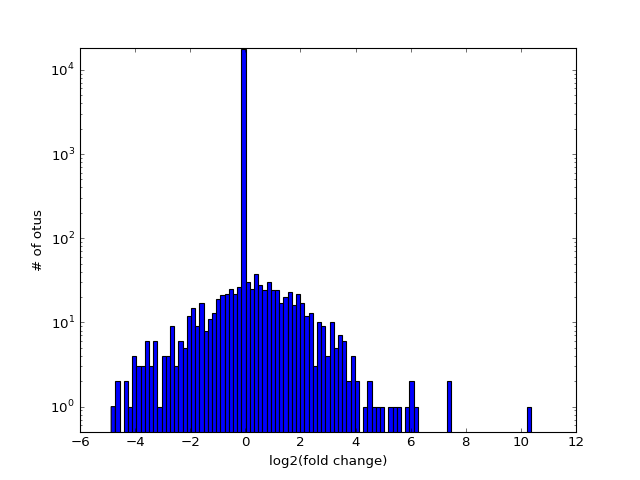

In [200]:
# se jin 4 weeks
sj28fc=teststability(sjf,time0val='1',time1val='4')

## differential expression
look how AG compares to the twins and pgp studies
and calculate the foldchange between the means for every bacteria

In [45]:
# join the experiments
fec=hs.joinexperiments(pgpf,twinsf)
fec=hs.joinexperiments(fec,ercf)
fec=hs.joinexperiments(fec,ibdf)
fec=hs.joinexperiments(fec,agf)

In [46]:
dd=hs.diffexpfastpermute(fec,'origexp','ag-6-2016.clean.min100.withtax.biom')

('7073 Samples left',)
('1214 Samples left',)
cnumperm 100, numbact 352, numnotuse 11277
cnumperm 1000, numbact 352, numnotuse 11277


('352 Bacteria left',)


<IPython.core.display.Javascript object>


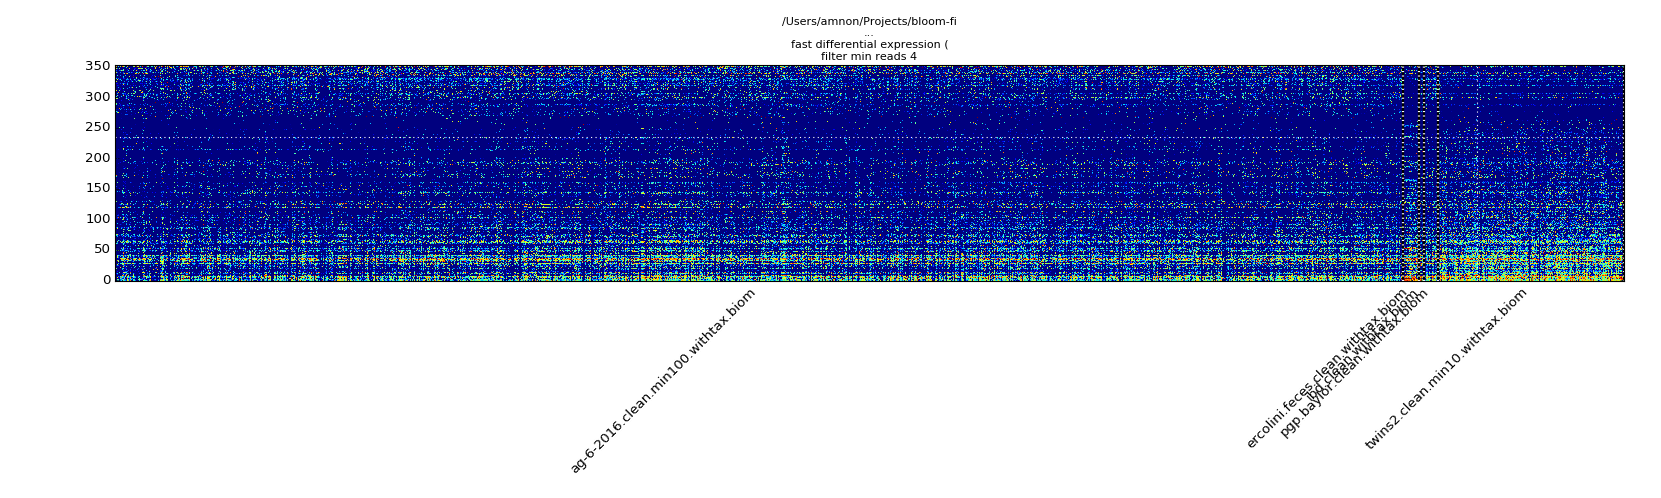

/Users/amnon/anaconda/envs/juphub/lib/python3.5/site-packages/matplotlib/artist.py:221: MatplotlibDeprecationWarning: This has been deprecated in mpl 1.5, please use the
axes property.  A removal date has not been set.
  warnings.warn(_get_axes_msg, mplDeprecation, stacklevel=1)
/Users/amnon/anaconda/envs/juphub/lib/python3.5/site-packages/matplotlib/__init__.py:1350: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


(<heatsequer.experiment.expclass.Experiment at 0x154be9978>,
 <matplotlib.axes._subplots.AxesSubplot at 0x129b9e470>)

In [47]:
hs.plotexp(dd,'origexp')

## Get the fold change of american gut compared to all other experiments

In [164]:
def get2expfc(exp1,exp2):
    """
    get the fold change for all bacteria in exp1/exp2
    """
    outfc={}
    numnotfound=0
    for cseq in exp1.seqs:
        dat1=exp1.data[exp1.seqdict[cseq]]
        dat1[dat1<1]=1
        if cseq not in exp2.seqdict:
            numnotfound+=1
            dat2=np.ones(len(exp2.samples))
        else:
            dat2=exp2.data[exp2.seqdict[cseq]]
        dat2[dat2<1]=1
        fc=np.mean(dat1)/np.mean(dat2)
        outfc[cseq]=fc
    print('%d sequences not found' % numnotfound)
    return outfc

In [165]:
fcpgp=get2expfc(agf,pgpf)

7867 sequences not found


In [63]:
fctwins=get2expfc(agf,twinsf)

6875 sequences not found


In [64]:
fcerc=get2expfc(agf,ercf)

7739 sequences not found


In [65]:
fcibd=get2expfc(agf,ibdf)

8377 sequences not found


In [90]:
fcpar=get2expfc(agf,parf)

6295 sequences not found


# find the blooming bacteria list
intersect the ag-vs-others and the storage studies fold changes

In [166]:
# load the old blooming bacteria list (for comparison)
oldbloomseqs,oldbloomnames=hs.readfastaseqs('/Users/amnon/Projects/bloom-filtering/data/oldbloom.fasta')

<IPython.core.display.Javascript object>


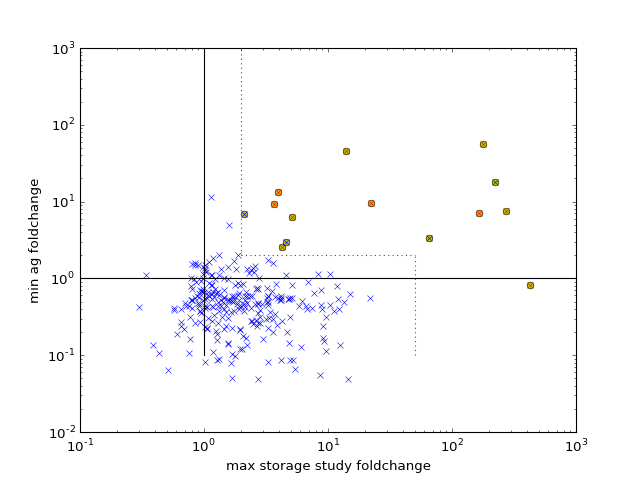

**(not in old bloom) Bacteria;Proteobacteria;Gammaproteobacteria;Enterobacteriales;Enterobacteriaceae;Providencia;;
score-11.557930, agfc-11.557930, maxfc-0.000000, mayo1fc--1.000000, mayo4fc--1.000000, sejin7fc--1.000000, sejin14fc--1.000000, sejin28fc--1.000000
**(not in old bloom) Bacteria;Proteobacteria;Gammaproteobacteria;Pseudomonadales;Pseudomonadaceae;Pseudomonas;;
score-2.457423, agfc-2.457423, maxfc-0.000000, mayo1fc--1.000000, mayo4fc--1.000000, sejin7fc--1.000000, sejin14fc--1.000000, sejin28fc--1.000000
**(not in old bloom) Bacteria;Proteobacteria;Gammaproteobacteria;Enterobacteriales;Enterobacteriaceae;
score-2.930602, agfc-2.930602, maxfc-0.000000, mayo1fc--1.000000, mayo4fc--1.000000, sejin7fc--1.000000, sejin14fc--1.000000, sejin28fc--1.000000
**(not in old bloom) Bacteria;Proteobacteria;Gammaproteobacteria;Enterobacteriales;Enterobacteriaceae;Proteus;;
score-20.268196, agfc-20.268196, maxfc-0.000000, mayo1fc--1.000000, mayo4fc--1.000000, sejin7fc--1.000000, sejin14fc-

In [216]:
# find the new blooming bacteria list
# test the min of the ag vs other experiments (y axis) and the max growth (in storage studies) (x axis)
plt.figure()
newbloom=[]
bloomscores=[]
bloomtax=[]
outfl=open('bloomingtable.txt','w')
outfl.write('taxonomy\tmin-ag-foldchange\tmax-storage-fc\tmayo-1-fc\tmayo-4-fc\tsj-7-fc\tsj-14-fc\tsj-28-fc\tsequence\n')

for idx,cseq in enumerate(dd.seqs):
    if cseq in agfc:
        cagfc=agfc[cseq]
    else:
        cagfc=-1

    if cseq in agf.seqdict:
        cagfc=1000000
    else:
        continue
    if cseq in fcpgp:
        cagfc=min(cagfc,fcpgp[cseq])
    else:
        cagfc=min(cagfc,50)
    if cseq in fctwins:
        cagfc=min(cagfc,fctwins[cseq])
    else:
        cagfc=min(cagfc,50)
    if cseq in fcerc:
        cagfc=min(cagfc,fcerc[cseq])
    else:
        cagfc=min(cagfc,50)
        
    maxfc=0
    if cseq in mayo4fc:
        cm4fc=mayo4fc[cseq]
        maxfc=max(maxfc,cm4fc)
    else:
        cm4fc=-1
    if cseq in mayo1fc:
        cm1fc=mayo1fc[cseq]
        maxfc=max(maxfc,cm1fc)
    else:
        cm1fc=-1
    if cseq[:124] in sj7fc:
        csj7fc=sj7fc[cseq[:124]]
        maxfc=max(maxfc,csj7fc)
    else:
        csj7fc=-1
    if cseq[:124] in sj14fc:
        csj14fc=sj14fc[cseq[:124]]
        maxfc=max(maxfc,csj14fc)
    else:
        csj14fc=-1
    if cseq[:124] in sj28fc:
        csj28fc=sj28fc[cseq[:124]]
        maxfc=max(maxfc,csj28fc)
    else:
        csj28fc=-1

        # the criteria when to call it a bloom
    if (maxfc>2 and cagfc>2) or (maxfc>50) or (cagfc>2 and maxfc==0):
        if cseq in oldbloomseqs:
            print('(in old bloom) '+dd.tax[idx])
        else:
            print('**(not in old bloom) '+dd.tax[idx])
        cscore=cagfc+maxfc
        print('score-%f, agfc-%f, maxfc-%f, mayo1fc-%f, mayo4fc-%f, sejin7fc-%f, sejin14fc-%f, sejin28fc-%f' % (cscore,cagfc, maxfc, cm1fc,cm4fc,csj7fc,csj14fc,csj28fc))
        outfl.write('%s\t%s\t%s\t%s\t%s\t%s\t%s\t%s\t%s\n' % (dd.tax[idx],cagfc,maxfc,cm1fc,cm4fc,csj7fc,csj14fc,csj28fc,cseq))
        newbloom.append(cseq)
        bloomscores.append(maxfc)
        bloomtax.append(dd.tax[idx])
        plt.plot(maxfc,cagfc,'oy')
    if cseq in oldbloomseqs:
        plt.plot(maxfc,cagfc,'xr')
    else:
        plt.plot(maxfc,cagfc,'xb')

outfl.close()
plt.xlabel('max storage study foldchange')
plt.ylabel('min ag foldchange')
plt.xscale('log')
plt.yscale('log')
plt.plot([0.1,1000],[1,1],'k')
plt.plot([1,1],[0.1,1000],'k')
plt.plot([2,50],[2,2],':r')
plt.plot([50,50],[0.1,2],':r')
plt.plot([2,2],[2,1000],':r')
print('total %d blooming bacteria' % len(newbloom))

In [172]:
# sort the blooming bacteria according to score
sv,si=hs.isort(bloomscores)
newbloom=hs.reorder(newbloom,si)
bloomtax=hs.reorder(bloomtax,si)
bloomscores=hs.reorder(bloomscores,si)

In [173]:
# the sorted list of blooming bacteria
for idx,ctax in enumerate(bloomtax):
    print('%d %s' % (bloomscores[idx],ctax))

0 Bacteria;Proteobacteria;Gammaproteobacteria;Enterobacteriales;Enterobacteriaceae;Providencia;;
0 Bacteria;Proteobacteria;Gammaproteobacteria;Pseudomonadales;Pseudomonadaceae;Pseudomonas;;
0 Bacteria;Proteobacteria;Gammaproteobacteria;Enterobacteriales;Enterobacteriaceae;
0 Bacteria;Proteobacteria;Gammaproteobacteria;Enterobacteriales;Enterobacteriaceae;Proteus;;
0 Bacteria;Firmicutes;Bacilli;Bacillales;Bacillaceae;Bacillus;clausii;
0 Bacteria;Firmicutes;Bacilli;Bacillales;Staphylococcaceae;Staphylococcus;;
2 Bacteria;Proteobacteria;Gammaproteobacteria;Pseudomonadales;Moraxellaceae;Acinetobacter;;
3 Bacteria;Firmicutes;Bacilli;Bacillales;Planococcaceae;Sporosarcina;ginsengi;
3 Bacteria;Proteobacteria;Gammaproteobacteria;Pseudomonadales;Pseudomonadaceae;Pseudomonas;;
4 Bacteria;Firmicutes;Bacilli;Lactobacillales;Lactobacillaceae;Lactobacillus;zeae;
4 Bacteria;Bacteroidetes;Bacteroidia;Bacteroidales;Bacteroidaceae;Bacteroides;uniformis;
5 Bacteria;Proteobacteria;Gammaproteobacteria;Ente

# test on the validation set

In [128]:
fecwithpar=hs.joinexperiments(fec,parf)

In [144]:
tt=hs.filterseqs(fecwithpar,newbloom)

('20 Bacteria left',)


<IPython.core.display.Javascript object>


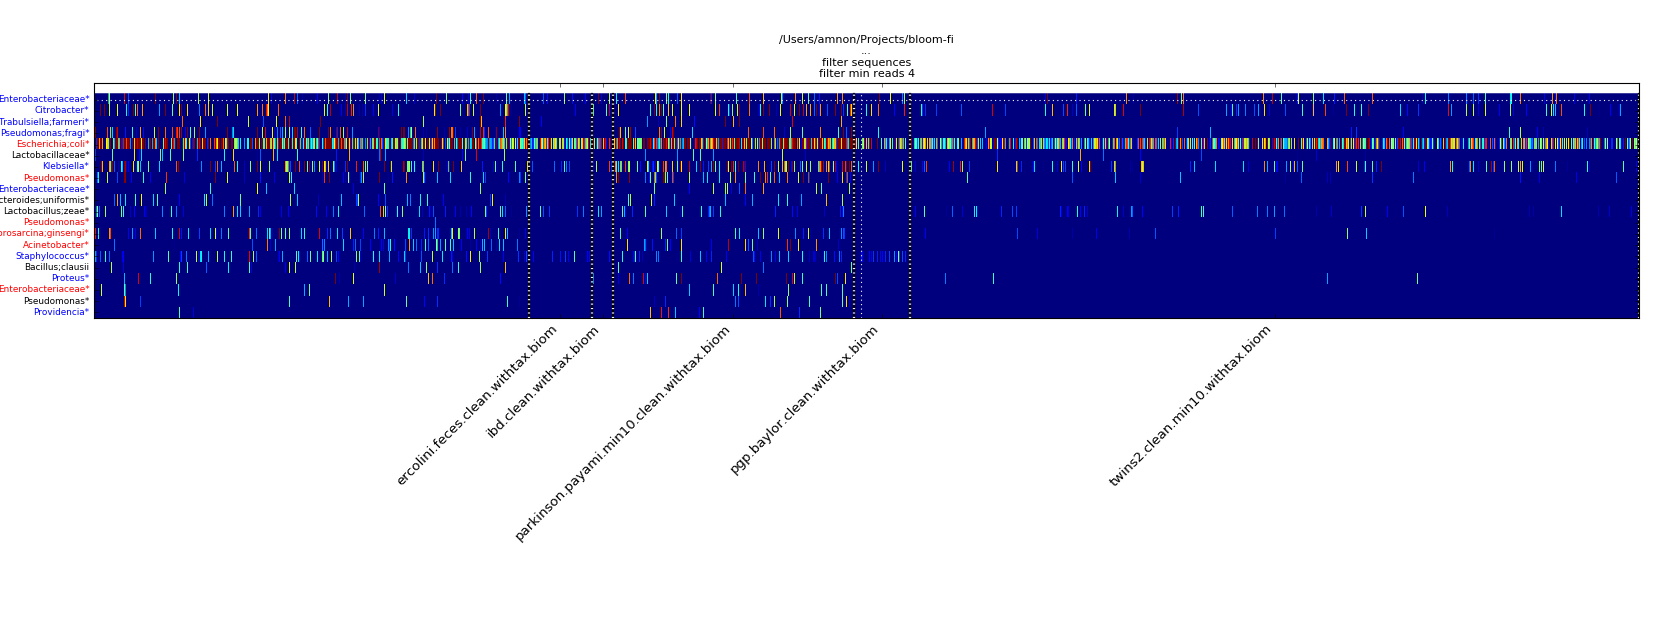

/Users/amnon/anaconda/envs/juphub/lib/python3.5/site-packages/matplotlib/artist.py:221: MatplotlibDeprecationWarning: This has been deprecated in mpl 1.5, please use the
axes property.  A removal date has not been set.
  warnings.warn(_get_axes_msg, mplDeprecation, stacklevel=1)


(<heatsequer.experiment.expclass.Experiment at 0x160f1ec50>,
 <matplotlib.axes._subplots.AxesSubplot at 0x315fcd748>)

In [145]:
hs.plotexp(tt,'origexp')

## calculate the ratio of parkinsons (shipped validation study) to other studies

In [177]:
nrat=get2expfc(parf,twinsf)
nrat2=get2expfc(parf,pgpf)
nrat3=get2expfc(parf,ercf)
newrat=np.zeros([len(newbloom),3])
for idx,cseq in enumerate(newbloom):
    if cseq in nrat:
        newrat[idx,0]=nrat[cseq]
    if cseq in nrat2:
        newrat[idx,1]=nrat2[cseq]
    if cseq in nrat3:
        newrat[idx,2]=nrat3[cseq]

1751 sequences not found
2229 sequences not found
2272 sequences not found


<IPython.core.display.Javascript object>


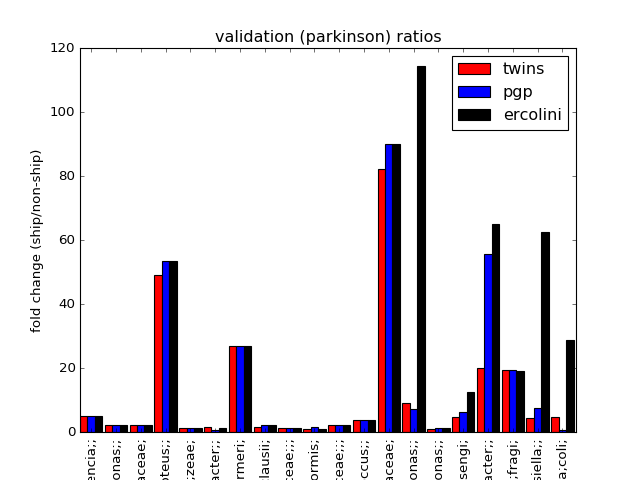

In [208]:
plt.figure()
plt.bar(np.arange(len(newbloom)),newrat[:,0],width=0.3,color='r')
plt.bar(np.arange(len(newbloom))+0.3,newrat[:,1],width=0.3,color='b')
plt.bar(np.arange(len(newbloom))+0.6,newrat[:,2],width=0.3,color='k')
plt.xticks(np.arange(len(bloomtax))+0.45,bloomtax,rotation=90)
#plt.yscale('log')
plt.ylabel('fold change (ship/non-ship)')
plt.legend(['twins','pgp','ercolini'])
plt.title('validation (parkinson) ratios')

## look at relation to shipment time in parkinson study
we don't see a nice relation - too noisy

('20 Bacteria left',)


<IPython.core.display.Javascript object>


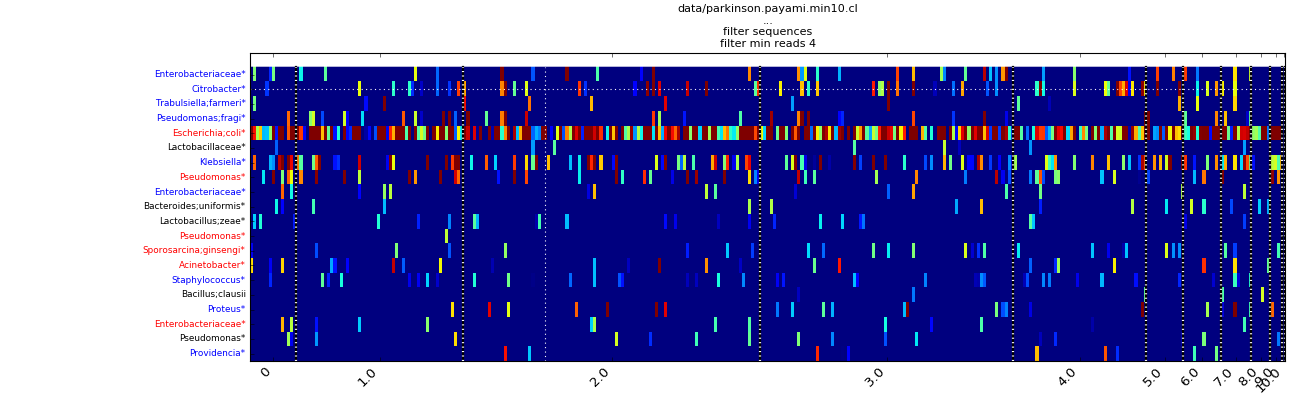

/Users/amnon/anaconda/envs/juphub/lib/python3.5/site-packages/matplotlib/artist.py:221: MatplotlibDeprecationWarning: This has been deprecated in mpl 1.5, please use the
axes property.  A removal date has not been set.
  warnings.warn(_get_axes_msg, mplDeprecation, stacklevel=1)


(<heatsequer.experiment.expclass.Experiment at 0x365417080>,
 <matplotlib.axes._subplots.AxesSubplot at 0x381b6ae80>)

In [181]:
tt=hs.filterseqs(parf,newbloom)
hs.plotexp(tt,'days_in_transit',numeric=True)